This notebook...

In [30]:
import pandas as pd
import numpy as np
import re

# For data viz
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# File system manangement
import os

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# pd.set_option('plotting.backend', 'plotly')
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 100)

%reload_ext autoreload
%autoreload 2

In [31]:
path = './application_train.csv'

df_2 = pd.read_csv(path)

# Utils functions

In [91]:
from preprocess_utils import encoding, handle_nans, scaling, sample_data
from classification_utils import *

from sklearn.preprocessing import MinMaxScaler 
from sklearn.neighbors import KDTree
from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split

# Models used
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

# Evaluating our models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer


def handle_outliers(df):
    ### DAYS_EMPLOYED_ANOM ###
    # Create an anomalous flag column
    df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243
    # Replace the anomalous values with nan
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    df.DAYS_EMPLOYED = df.DAYS_EMPLOYED.abs()
    print(f'(DAYS_EMPLOYED) {df["DAYS_EMPLOYED_ANOM"].sum()} anomalous values found.')

    ### DAYS columns ###
    for col in df.columns[df.columns.str.contains('DAYS')]:
        df[col] = df[col].abs()

    ### Categorical XNA ###
    for col_name in df.select_dtypes(include='object').columns:
        if 'XNA' in (df[col_name].unique()):
            nb_xna = df[col_name].value_counts().loc['XNA']
            print(f'{nb_xna} XNAs found in {col_name}')
            df[col_name].replace('XNA', np.nan, inplace=True)

    return df

def train_model(X_train, y_train, model, grid, scoring='roc_auc'):
    model_cv = GridSearchCV(model, grid, cv=5, scoring=scoring, verbose=2, error_score='raise', n_jobs=-1)

    # Train on the training data
    model_cv.fit(X_train, y_train)
    
    return model_cv

def business_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0] ; tp = cm[1,1] 
    fn = cm[1,0] ; fp = cm[0,1]

    if type(y_true) == np.ndarray:
        max_score = np.unique(y_true, return_counts=True)[1][0]*2 + np.unique(y_true, return_counts=True)[1][0]*1
    else:
        max_score = np.unique(y_true.values, return_counts=True)[1][0]*2 + np.unique(y_true.values, return_counts=True)[1][0]*1


    score = (tn*2 + tp*1 + fp*(-2) + fn*(-20) )
    
    return score

business_scoring = make_scorer(business_score, greater_is_better=True)


def classif_score(y_true, X_test, model, name_model, display_cm = True):
    
    y_pred = model.predict(X_test).astype('int')
    
    if display_cm:
        cm = confusion_matrix(y_true, y_pred)
        make_confusion_matrix(cm, sum_stats=False, cbar=False, figsize=(4,4), title='Confusion Matrix')

    data = {'Accuracy': round(accuracy_score(y_true, y_pred), 3),
          'AUROC': round(roc_auc_score(y_true, model.predict_proba(X_test)[:,1]), 3),
          'Precision': round(precision_score(y_true, y_pred), 3),
          'Recall': round(recall_score(y_true, y_pred), 3),
          'F1-Score': round(f1_score(y_true, y_pred), 3),
          'FBeta-Score': round(fbeta_score(y_true, y_pred, beta=3, average='binary'), 3), # Report only for the positive label
          'Business_score': round(business_score(y_true, y_pred) ,3)
        }
    return pd.DataFrame(data, index=[name_model])

def adding_features(df, target):
    age = df.DAYS_BIRTH/365
    
    # AMT_CREDIT: Credit amount of the loan ; AMT_ANNUITY: Loan annuity
    credit_annuity_ratio = df.AMT_CREDIT /  df.AMT_ANNUITY
    credit_goods_price_ratio =  df.AMT_CREDIT / df.AMT_GOODS_PRICE
    credit_income_ratio =  df.AMT_CREDIT / df.AMT_INCOME_TOTAL
    annuity_income_ratio = df.AMT_ANNUITY / df.AMT_INCOME_TOTAL
    days_employed_life = df.DAYS_EMPLOYED / df.DAYS_BIRTH
    
    
    tmp = df[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']]
    tmp = pd.concat([tmp, credit_annuity_ratio.rename('CREDIT_ANNUITY_RATIO')], axis=1) 
    
#     # Computing Nearest Neigbors
#     scaler = MinMaxScaler()
#     scaled = scaler.fit_transform(tmp)
    
#     kdt = KDTree(scaled)
    
#     mean_target_50_nn = []

#     for index, row in enumerate(scaled):
#         indices = kdt.query(row.reshape(1,-1), 50, return_distance = False) # Compute the 50 nearest neighbors of a given line
#         if target.iloc[indices[0]].mean() >= 0.5: # Determine the mean of the target of the 500nearest neighbors
#             mean_target_50_nn.append(1)
#         else: 
#             mean_target_50_nn.append(0)
            
    # Adding new features to the dataframe
    df['AGE'] = age
    df['CREDIT_ANNUITY_RATIO'] = credit_annuity_ratio
    df['CREDIT_GOODS_PRICE_RATIO'] = credit_goods_price_ratio
    df['CREDIT_INCOME_RATIO'] = credit_income_ratio
    df['ANNUITY_INCOME_RATIO'] = annuity_income_ratio
    df['DAYS_EMPLOYED_LIFE'] = days_employed_life
    
#     df['TARGET_50_NN'] = mean_target_50_nn
    
    print('Features added.')
    
    return df

def delete_correl_features(df, to_drop):
    return df.drop(to_drop, axis=1)

def delete_low_var(X_train, X_test, var_th=0.01):  
    selector = VarianceThreshold(threshold=var_th)
    selector.fit(X_train)
    col_to_drop = X_train.columns[~selector.get_support()] # Easier to debug
    print(f'With var_th={var_th}: {len(col_to_drop)} columns dropped.')
    X_train = X_train.drop(col_to_drop, axis=1)
    X_test = X_test.drop(col_to_drop, axis=1)
    
    return X_train, X_test, col_to_drop

from sklearn.feature_selection import SelectFromModel

def delete_from_model(X_train, y_train, X_test, threshold_from_model='mean'):
    selector = SelectFromModel(DecisionTreeClassifier(random_state=42), threshold=threshold_from_model)
    selector.fit(X_train, y_train)
    
    col_to_drop = X_train.columns[~selector.get_support()] # Easier to debug
    print(f'With threshold={threshold_from_model}: {len(col_to_drop)} columns dropped.')
    X_train = X_train.drop(col_to_drop, axis=1)
    X_test = X_test.drop(col_to_drop, axis=1)
    
    return X_train, X_test, col_to_drop

# Features Engineering

## Creation of new features

Here, we create some new features in order to improve the performance of the model:
 - Age is a pretty explicit feature
 - credit_annuity_ratio is the ratio a loan is compared to the whole credit (between 0 and 1)
 - credit_goods_ratio is the ratio of the credit compared to the price the customer will buy with
 - credit_income_ratio is the ratio of the credit compared to the total income of the client
 - annuity_income_ratio is the ratio of the annuity compared to the income of the client
 - days_employed_life is the % of time spent working in the whole life of the client
 - target_50_nn is the mean of the target of the 50 others customers "similar" (Nearest neighbors using EXT_SOURCEs and credit_annuity_ratio)

## Deleting correlated features

<AxesSubplot:>

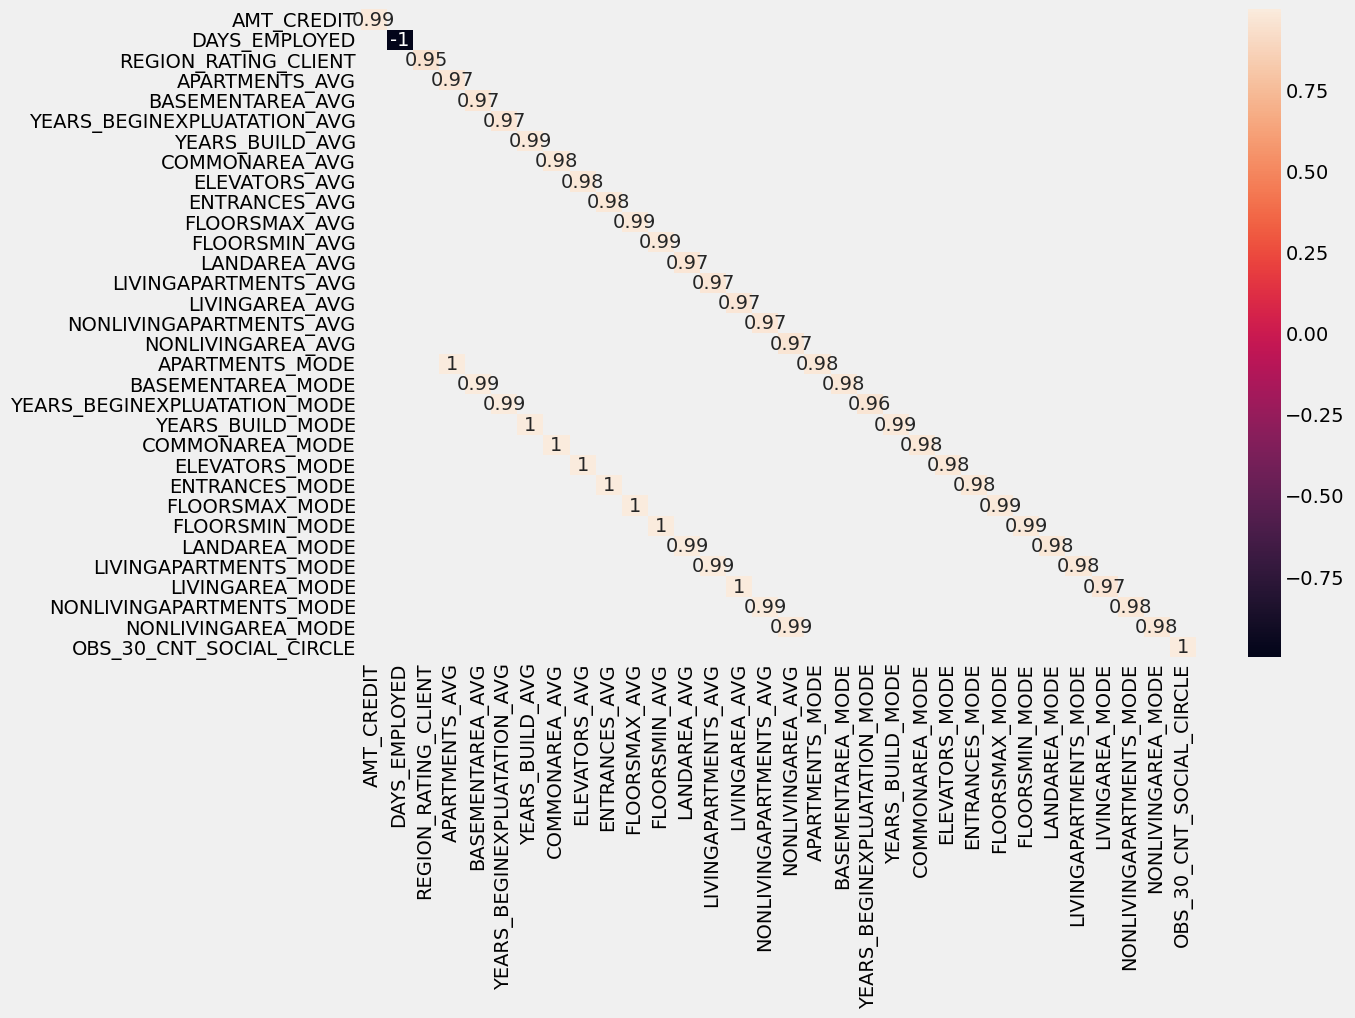

In [26]:
corr = df_2.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
corr[corr.abs() < 0.95] = np.nan

corr = corr.dropna(how='all').dropna(how='all', axis=1)
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values)# (corr

In [27]:
high_corr = pd.DataFrame(columns={'col1', 'col2', 'value'})

for col in corr.columns:
    for index in corr.index:
        if not (np.isnan(corr.loc[index][col])):
            high_corr = high_corr.append(pd.DataFrame({'col1':[index], 'col2':[col], 'value':[corr.loc[index][col]]}), ignore_index=True)
            
high_corr.sort_values(by='col2')

,value,col1,col2
0,0.986968,AMT_GOODS_PRICE,AMT_CREDIT
4,0.995081,APARTMENTS_MEDI,APARTMENTS_AVG
3,0.973259,APARTMENTS_MODE,APARTMENTS_AVG
31,0.977193,APARTMENTS_MEDI,APARTMENTS_MODE
5,0.973496,BASEMENTAREA_MODE,BASEMENTAREA_AVG
6,0.994317,BASEMENTAREA_MEDI,BASEMENTAREA_AVG
32,0.977938,BASEMENTAREA_MEDI,BASEMENTAREA_MODE
11,0.977147,COMMONAREA_MODE,COMMONAREA_AVG
12,0.995978,COMMONAREA_MEDI,COMMONAREA_AVG
35,0.979887,COMMONAREA_MEDI,COMMONAREA_MODE


In [28]:
to_keep = ['YEAR_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'REGION_RATING_CLIENT', 'NONLIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'LIVING_AREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LANDAREA_MEDI', 'FLOORSMIN_MEDI',
          'FLOORSMIN_MEDI', 'FLOORSMAX_MEDI', 'ENTRANCES_MEDI', 'COMMONAREA_MEDI', 'BASEMENTAREA_MEDI', 'APARTMENTS_MEDI']

to_drop = ['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'REGION_RATING_CLIENT_W_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE',
          'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE',
           'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LANDAREA_AVG', 'LANDAREA_MODE', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG', 
           'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'FLAG_EMP_PHONE'
          ]

## Variance Threshold

In [29]:
(X_train_2.var() < 0.01).sum()

NameError: name 'X_train_2' is not defined

I saw a certain numbers of features with very low variance.

# Modelling

For the following training, we'll focus on the two models that gave us the best Business score: Random Forest et Light GBM

Here we are going to measure the impact of feature engineering on our results

In [ ]:
def preprocessing_fe(data, delete_correl = False, adding_f = False, low_var = False, var_th = 0.01, from_model=False, s=MinMaxScaler, return_object_to_ser=False, **params_scaler):
    df = data.copy(deep=True)
    
    col_to_drop = []
    
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) # Delete special JSON characters from column names
    if delete_correl:
        to_drop = ['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'REGION_RATING_CLIENT_W_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE',
              'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE',
               'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE', 'LANDAREA_AVG', 'LANDAREA_MODE', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG', 
               'ENTRANCES_AVG', 'ENTRANCES_MODE', 'ELEVATORS_AVG', 'ELEVATORS_MODE', 'COMMONAREA_AVG', 'COMMONAREA_MODE', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG', 'APARTMENTS_AVG', 'APARTMENTS_MODE', 'FLAG_EMP_PHONE'
              ]
        col_to_drop.append(to_drop)
        df = delete_correl_features(df, to_drop)

    print("Handling Outliers".center(50, '-'))
    df = handle_outliers(df)
    print()

    print("Encoding".center(50, '-'))
    df, col_to_le, enc = encoding(df) # TARGET will not be treated as categorical variables here
    print()  

    print('Splitting in train/test set'.center(50, '-'))
    train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['TARGET'])
    X_train = train.drop('TARGET', axis=1);   y_train = train.TARGET
    X_test = test.drop('TARGET', axis=1);  y_test = test.TARGET
    print('train:', X_train.shape);  print('test:', X_test.shape)
    print()
    
    print("Handling NaNs".center(50, '-'))
    print('train: ', end=' '); X_train, imputer = handle_nans(X_train)
    print('test: ', end=' '); print(f'{X_test.isna().sum().sum()} nans found.')
    col_num = X_test.select_dtypes(include=np.number).columns
    X_test[col_num] = imputer.transform(X_test[col_num])
    print()
    
    if adding_f:
        print("Adding Features".center(50, '-'))
        print('train:', end=' '); X_train = adding_features(X_train, y_train)
        print('test: ', end=' '); X_test = adding_features(X_test, y_test)
        print()
        
    if low_var:
        print("Deleting low variance features".center(50, '-'))
        X_train, X_test, to_drop = delete_low_var(X_train, X_test, var_th)
        col_to_drop.append(to_drop)
        print()
        
        
    if from_model:
        print("Deleting with model features importance".center(50, '-'))
        X_train, X_test, to_drop = delete_from_model(X_train, y_train, X_test, threshold_from_model='mean')
        col_to_drop.append(to_drop)
        print()

    print("Scaling".center(50, '-'))
    X_train, X_test, scaler = scaling(X_train, X_test, s=s,  **params_scaler)
    print()    
    

    if return_object_to_ser:
        to_serialize = {'scaler': scaler, 'imputer': imputer,
                  'le':col_to_le, 'one_hot': enc, 
                  'to_drop': to_drop.append(col_to_drop)}
        return X_train, y_train, X_test, y_test, to_serialize
    else:
        return X_train, y_train, X_test, y_test

### Adding features

#### Random Forest

In [ ]:
%%time
grid = {
    'max_depth': np.linspace(5,15,5).astype('int'), #Top 1 
    'min_samples_split': np.linspace(50,300,5).astype('int'),
}


X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=False, low_var=False)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

rf_cv = train_model(X_train_s2, y_train_s2, RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced_subsample'), grid=grid, scoring=business_scoring)
print(rf_cv.best_estimator_)
rf_cv_no_fe = classif_score(y_test_2, X_test_2, rf_cv.best_estimator_, 'Without FE', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train: 6751520 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 241)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 25 candidates, totalling 125 fits
RandomForestClassifier(class_weight='balanced_subsample', max_depth=15,
 

In [ ]:
%%time
grid = {
    'max_depth': np.linspace(5,15,5).astype('int'), #Top 1 
    'min_samples_split': np.linspace(50,1000,10).astype('int'),
}

X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True, low_var=False)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

rf_cv = train_model(X_train_s2, y_train_s2, RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced_subsample'), grid=grid, scoring=business_scoring)
print(rf_cv.best_estimator_)
rf_cv_add_fe = classif_score(y_test_2, X_test_2, rf_cv.best_estimator_, 'Features added', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train: 6751520 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}

-----------------Adding Features------------------
train: Features added.
test:  Features added.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 248)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 50 candid

In [ ]:
pd.concat([rf_cv_no_fe, rf_cv_add_fe])

,Accuracy,AUROC,Precision,Recall,F1-Score,FBeta-Score,Business_score
Without FE,0.857,0.720,0.223,0.312,0.26,0.300,24687
Features added,0.850,0.735,0.229,0.362,0.28,0.342,27298


---

**Business score improvement of 2500**

#### LBGM

In [ ]:
grid = {
      'num_leaves':np.linspace(25, 100, 4).astype('int'),
      'max_depth': np.linspace(1,5,3).astype('int'), # weak learner
      'reg_alpha': [0, 0.5, 1], # np.linspace(0,1,4),
      'reg_lambda': [0, 0.5, 1], # np.linspace(0,1,4)
} 

In [ ]:
%%time
X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=False, low_var=False)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

gbm_cv = train_model(X_train_s2.values, y_train_s2.values, lgb.LGBMClassifier(random_state=42, learning_rate=0.2, n_estimators=200, class_weight='balanced'), grid=grid, scoring=business_scoring)
print(gbm_cv.best_estimator_)
gbm_cv_no_fe = classif_score(y_test_2, X_test_2, gbm_cv.best_estimator_, 'Without FE', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 241)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 540 fits
LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=5,
               n_estimators=200, num_leaves=50, random_state=42, reg_alpha=0.5,
               reg_lambda=1)


In [ ]:
%%time
X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True, low_var=False)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

gbm_cv = train_model(X_train_s2.values, y_train_s2.values, lgb.LGBMClassifier(random_state=42, learning_rate=0.2, n_estimators=200, class_weight='balanced'), grid=grid, scoring=business_scoring)
print(gbm_cv.best_estimator_)
gbm_cv_add_fe = classif_score(y_test_2, X_test_2, gbm_cv.best_estimator_, 'Feature added', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 247)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 540 fits
LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=5,
           

In [ ]:
pd.concat([gbm_cv_no_fe, gbm_cv_add_fe])

,Accuracy,AUROC,Precision,Recall,F1-Score,FBeta-Score,Business_score
Without FE,0.813,0.720,0.196,0.424,0.269,0.380,23543
Feature added,0.822,0.724,0.206,0.421,0.277,0.381,25423


---

**Business score improvement of ~2000**

### Feature Selection

Here we are going to evaluate differents ways of performing feature selection in order to optimize our score.

#### Random Forest

In [ ]:
grid = {
    'max_depth': np.linspace(5,15,5).astype('int'), #Top 1 
    'min_samples_split': np.linspace(50,300,5).astype('int'),
}

##### Without FS

In [ ]:
%%time
X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

rf_cv = train_model(X_train_s2, y_train_s2, RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators=200), grid=grid, scoring=business_scoring)
print(rf_cv.best_estimator_)
rf_cv_no_fs = classif_score(y_test_2, X_test_2, rf_cv.best_estimator_, 'Without FS', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train: 6751520 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}

-----------------Adding Features------------------
train: Features added.
test:  Features added.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 248)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 25 candid

##### Correlated features

In [ ]:
%%time

X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=True, adding_f=True)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

rf_cv = train_model(X_train_s2, y_train_s2, RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators=200), grid=grid, scoring=business_scoring)
print(rf_cv.best_estimator_)
rf_cv_delete_correl = classif_score(y_test_2, X_test_2, rf_cv.best_estimator_, 'Deleted Correl', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 210)
test: (61503, 210)

------------------Handling NaNs-------------------
train: 2727123 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  683164 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}

-----------------Adding Features------------------
train: Features added.
test:  Features added.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 217)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 25 candida

##### Low variance features

In [ ]:
X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True, low_var=True, var_th=0.01)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

rf_cv = train_model(X_train_s2, y_train_s2, RandomForestClassifier(random_state=42,class_weight='balanced_subsample',  n_estimators=200), grid=grid, scoring=business_scoring)
print(rf_cv.best_estimator_)
rf_cv_delete_low_var = classif_score(y_test_2, X_test_2, rf_cv.best_estimator_, 'Deleted Low Var', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train: 6751520 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}

-----------------Adding Features------------------
train: Features added.
test:  Features added.

----------Deleting low variance features----------
With var_th=0.01: 126 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 122)
(30000,)
0  

##### Low variance and correlated features

In [ ]:
%%time

X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=True, adding_f=True, low_var=True, var_th=0.01)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

rf_cv = train_model(X_train_s2, y_train_s2, RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators=200), grid=grid, scoring=business_scoring)
print(rf_cv.best_estimator_)
rf_cv_delete_correl_and_low_var = classif_score(y_test_2, X_test_2, rf_cv.best_estimator_, 'Deleted Low Var + correl', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 210)
test: (61503, 210)

------------------Handling NaNs-------------------
train: 2727123 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  683164 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}

-----------------Adding Features------------------
train: Features added.
test:  Features added.

----------Deleting low variance features----------
With var_th=0.01: 101 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 116)
(30000,)
0   

##### Low features importance

In [ ]:
%%time

X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True, from_model=True)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

rf_cv = train_model(X_train_s2, y_train_s2, RandomForestClassifier(random_state=42, n_estimators=200), grid=grid, scoring=business_scoring)
print(rf_cv.best_estimator_)
rf_cv_delete_with_model = classif_score(y_test_2, X_test_2, rf_cv.best_estimator_, 'Deleted with model', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train: 6751520 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.
Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}

-----------------Adding Features------------------
train: Features added.
test:  Features added.

-----Deleting with model features importance------
With threshold=mean: 205 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 43)
(30000,)
0

##### Results

In [ ]:
pd.concat([rf_cv_no_fs, rf_cv_delete_correl, rf_cv_delete_low_var, rf_cv_delete_correl_and_low_var, rf_cv_delete_with_model])

,Accuracy,AUROC,Precision,Recall,F1-Score,FBeta-Score,Business_score
Without FS,0.854,0.732,0.234,0.353,0.281,0.336,27595
Deleted Correl,0.871,0.736,0.248,0.292,0.268,0.287,26668
Deleted Low Var,0.852,0.746,0.238,0.379,0.293,0.358,29243
Deleted Low Var + correl,0.854,0.742,0.233,0.352,0.281,0.335,27546
Deleted with model,0.919,0.718,1.000,0.000,0.001,0.000,13818


---

**Best amelioration with the suppresion of low variance + correlated variables (~1100)**

#### LBGM

In [ ]:
grid = {
      'num_leaves':np.linspace(25, 100, 4).astype('int'),
      'max_depth': np.linspace(1,5,3).astype('int'), # weak learner
      'reg_alpha': [0, 0.5, 1], # np.linspace(0,1,4),
      'reg_lambda': [0, 0.5, 1], # np.linspace(0,1,4)
}

##### Without FS

In [ ]:
%%time 
X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True, low_var=False)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

gbm_cv = train_model(X_train_s2.values, y_train_s2.values, lgb.LGBMClassifier(random_state=42, learning_rate=0.2, n_estimators=200, class_weight='balanced'), grid=grid, scoring=business_scoring)
print(gbm_cv.best_estimator_)
gbm_cv_no_fs = classif_score(y_test_2, X_test_2, gbm_cv.best_estimator_, 'Without FSelection', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 247)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 540 fits
LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=5,
           

##### Correlated features

In [ ]:
%%time
X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=True, adding_f=True, low_var=False)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

gbm_cv = train_model(X_train_s2.values, y_train_s2.values, lgb.LGBMClassifier(random_state=42, learning_rate=0.2, n_estimators=200, class_weight='balanced'), grid=grid, scoring=business_scoring)
print(gbm_cv.best_estimator_)
gbm_cv_delete_correl = classif_score(y_test_2, X_test_2, gbm_cv.best_estimator_, 'Deleted Correl', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 210)
test: (61503, 210)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  683164 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 216)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 540 fits
LGBMClassifier(class_weight='balanced', learning_rate=0.2, max_depth=5,
            

##### Low variance features

In [ ]:
%%time
X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True, low_var=True)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

gbm_cv = train_model(X_train_s2.values, y_train_s2.values, lgb.LGBMClassifier(random_state=42, learning_rate=0.2, n_estimators=200, class_weight='balanced'), grid=grid, scoring=business_scoring)
print(gbm_cv.best_estimator_)
gbm_cv_low_var = classif_score(y_test_2, X_test_2, gbm_cv.best_estimator_, 'Deleted low variance', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

----------Deleting low variance features----------
With var_th=0.01: 125 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 122)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 5

##### Low variance and correlated features

In [ ]:
%%time

X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=True, adding_f=True, low_var=True)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

gbm_cv = train_model(X_train_s2.values, y_train_s2.values, lgb.LGBMClassifier(random_state=42, learning_rate=0.2, n_estimators=200, class_weight='balanced'), grid=grid, scoring=business_scoring)
print(gbm_cv.best_estimator_)
gbm_cv_delete_correl_and_low_var = classif_score(y_test_2, X_test_2, gbm_cv.best_estimator_, 'Deleted correl + low variance', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 210)
test: (61503, 210)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  683164 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

----------Deleting low variance features----------
With var_th=0.01: 100 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 116)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling 54

##### Low features importance

In [ ]:
%%time

X_train_2, y_train_2, X_test_2, y_test_2 = preprocessing_fe(df_2, delete_correl=False, adding_f=True, low_var=False, from_model=True)
X_train_s2, y_train_s2 = sample_data(X_train_2, y_train_2, nb_samples=30000)

gbm_cv = train_model(X_train_s2.values, y_train_s2.values, lgb.LGBMClassifier(random_state=42, learning_rate=0.2, n_estimators=200, class_weight='balanced'), grid=grid, scoring=business_scoring)
print(gbm_cv.best_estimator_)
gbm_cv_delete_with_model = classif_score(y_test_2, X_test_2, gbm_cv.best_estimator_, 'Deleted with model', display_cm=False)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

-----Deleting with model features importance------
With threshold=mean: 208 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}

(30000, 39)
(30000,)
0    0.919267
1    0.080733
Name: TARGET, dtype: float64
Fitting 5 folds for each of 108 candidates, totalling

##### Results

In [ ]:
pd.concat([gbm_cv_no_fs, gbm_cv_delete_correl, gbm_cv_low_var, gbm_cv_delete_correl_and_low_var, gbm_cv_delete_with_model])

,Accuracy,AUROC,Precision,Recall,F1-Score,FBeta-Score,Business_score
Without FSelection,0.816,0.720,0.201,0.429,0.274,0.386,24688
Deleted Correl,0.821,0.729,0.208,0.433,0.281,0.391,26200
Deleted low variance,0.822,0.724,0.208,0.427,0.280,0.387,26002
Deleted correl + low variance,0.820,0.724,0.202,0.419,0.273,0.379,24658
Deleted with model,0.818,0.724,0.204,0.433,0.278,0.390,25452


**Best amelioration with suppression of correlated features (+1400)**

# Final models

Our best model is the random forest (with added features + low_variance deletion), we decide to keep this one

In [92]:
X_train_2, y_train_2, X_test_2, y_test_2, to_ser = preprocessing_fe(df_2, delete_correl=False, adding_f=True, low_var=True, 
                                                                    var_th=0.01, return_object_to_ser=True)

----------------Handling Outliers-----------------
(DAYS_EMPLOYED) 55374 anomalous values found.
4 XNAs found in CODE_GENDER
55374 XNAs found in ORGANIZATION_TYPE

---------------------Encoding---------------------
3 columns were label encoded.
119 columns were one-hot encoded.

-----------Splitting in train/test set------------
train: (246008, 241)
test: (61503, 241)

------------------Handling NaNs-------------------
train:  Imputing with <class 'sklearn.impute._base.SimpleImputer'> 
Strategy: median ; Params: {}
test:  1691948 nans found.

-----------------Adding Features------------------
train: Features added.
test:  Features added.

----------Deleting low variance features----------
With var_th=0.01: 125 columns dropped.

---------------------Scaling----------------------
Scaling with <class 'sklearn.preprocessing._data.MinMaxScaler'> 
Params: {}



,Accuracy,AUROC,Precision,Recall,F1-Score,FBeta-Score,Business_score
,0.811,0.752,0.209,0.481,0.291,0.426,27768


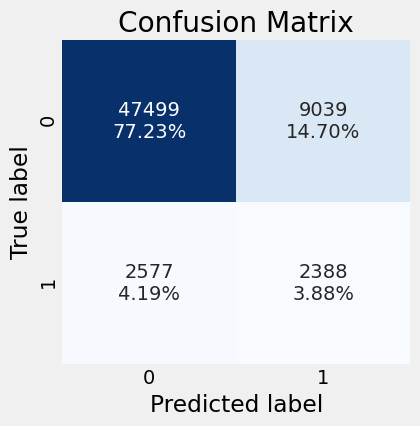

In [93]:
# training with the whole dataset
best_model = RandomForestClassifier(random_state=42, n_jobs=-1,
                                    n_estimators=200,
                                    max_depth=15,
                                   min_samples_split=50,
                                   class_weight=('balanced_subsample'))

best_model.fit(X_train_2, y_train_2)
classif_score(y_test_2, X_test_2, best_model, '', display_cm=True)

In [94]:
import pickle

path_rf = './fastapi/rf_objects/'

scaler_rf = to_ser['scaler']
imputer_rf = to_ser['imputer']
le_rf = to_ser['le']
one_hot_rf = to_ser['one_hot']
to_drop = to_ser['to_drop']

pickle.dump(best_model, open(path_rf+'rf_best', 'wb'))
pickle.dump(scaler_rf, open(path_rf+'scaler_rf', 'wb'))
pickle.dump(imputer_rf, open(path_rf+'imputer_rf', 'wb'))
pickle.dump(le_rf, open(path_rf+'le_rf', 'wb'))
pickle.dump(one_hot_rf, open(path_rf+'one_hot_rf', 'wb'))
pickle.dump(to_drop, open(path_rf+'to_drop', 'wb'))

pickle.dump(y_test_2, open(path_rf+'y_test_rf', 'wb'))
pickle.dump(X_test_2, open(path_rf+'X_test_rf', 'wb'))

## Choosing the best threshold

In [19]:
from sklearn.metrics import precision_recall_curve

In [20]:
def plot_business_score_vs_threshold(y_true, y_scores, thresholds=np.linspace(0,1,21)):
    b_score = []
    for t in thresholds:
        y_labels = [1 if y >= t else 0 for y in y_scores]
        b_score.append(business_score(y_true, y_labels))
        
    plt.figure(figsize=(8, 8))
    plt.title("Business score vs thresholds")
    plt.plot(thresholds, b_score)
    plt.ylabel("Business score")
    plt.xlabel("Threshold")
    plt.xticks(thresholds, rotation=45)
    return b_score, thresholds

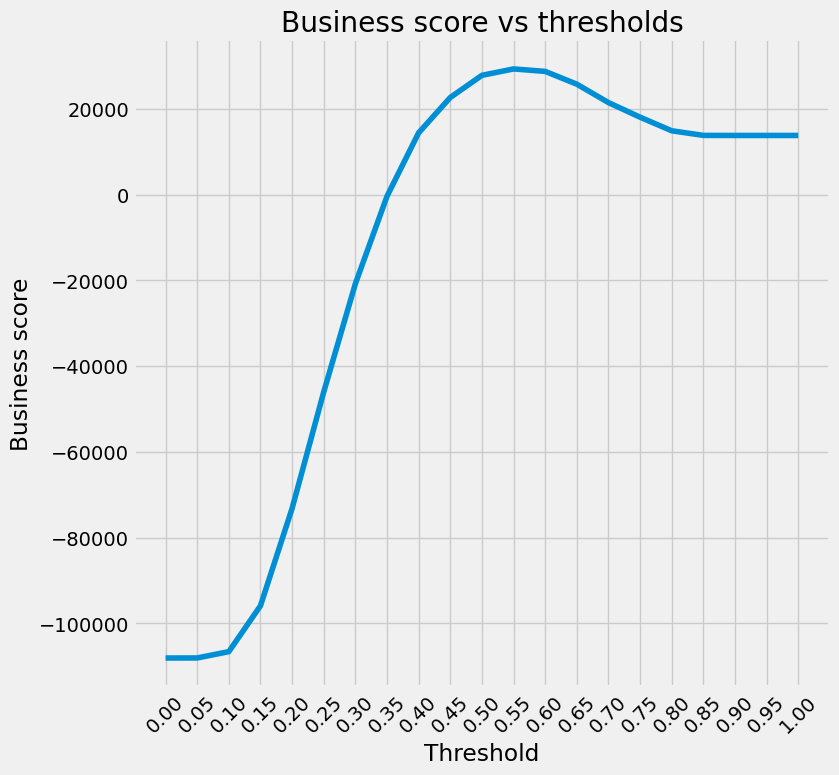

In [21]:
y_scores = best_model.predict_proba(X_test_2)[:,1]
b_scores, ths = plot_business_score_vs_threshold(y_test_2, y_scores)

**Best threshold = 0.55**